### Transformer Based Image Captioning

In [ ]:
import os
import gc
import random
import math
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from collections import Counter
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

## Step 1: Load and Clean Captions
In this step:
- Captions are loaded from the `Flickr8k.token.txt` file.
- Special tokens (`<start>` and `<end>`) are added to captions.
- Single-character words are removed, and captions are padded to a uniform length.


In [ ]:
##################################################
# STEP 1: Load and Clean Captions
##################################################
captions_file = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k.token.txt'
images_dir = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/'

# Load captions
captions = pd.read_csv(captions_file, delimiter='\t', header=None, names=['image_name', 'comment'])
captions['comment_number'] = captions['image_name'].apply(lambda x: int(x.split('#')[-1]))
captions['image_name'] = captions['image_name'].apply(lambda x: x.split('#')[0])
captions.dropna(inplace=True)

# Remove any rows that have filenames ending with .jpg.1
captions = captions[~captions['image_name'].str.endswith('.jpg.1')]

print("Number of unique images:", captions['image_name'].nunique())
print("Number of captions:", len(captions))

def remove_single_char_word(word_list):
    return [w for w in word_list if len(w) > 1]

captions['cleaned_caption'] = captions['comment'].apply(
    lambda c: ['<start>'] + [w.lower() if w.isalpha() else '' for w in c.split()] + ['<end>']
)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(remove_single_char_word)

captions['seq_len'] = captions['cleaned_caption'].apply(lambda x: len(x))
max_seq_len = captions['seq_len'].max()
print("Max sequence length:", max_seq_len)

captions.drop(['seq_len'], axis=1, inplace=True)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(
    lambda cap: cap + ['<pad>']*(max_seq_len-len(cap))
)

word_list = captions['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')
word_dict = Counter(word_list)
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)

vocab_size = len(word_dict)
print("Vocabulary size:", vocab_size)

index_to_word = {idx: w for idx, w in enumerate(word_dict)}
word_to_index = {w: idx for idx, w in enumerate(word_dict)}
captions['text_seq'] = captions['cleaned_caption'].apply(lambda cap: [word_to_index[w] for w in cap])

captions = captions.sort_values(by='image_name')
train = captions.iloc[:int(0.9*len(captions))]
valid = captions.iloc[int(0.9*len(captions)):]

print("Train samples:", len(train), "Unique train images:", train['image_name'].nunique())
print("Valid samples:", len(valid), "Unique valid images:", valid['image_name'].nunique())

unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()

# We'll use CPU for extraction
cpu_device = torch.device("cpu")
print("Feature Extraction Device:", cpu_device)

##################################################
# STEP 1: Load and Clean Captions
##################################################
captions_file = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k.token.txt'
images_dir = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/'

# Load captions
captions = pd.read_csv(captions_file, delimiter='\t', header=None, names=['image_name', 'comment'])
captions['comment_number'] = captions['image_name'].apply(lambda x: int(x.split('#')[-1]))
captions['image_name'] = captions['image_name'].apply(lambda x: x.split('#')[0])
captions.dropna(inplace=True)

# Remove any rows that have filenames ending with .jpg.1
captions = captions[~captions['image_name'].str.endswith('.jpg.1')]

print("Number of unique images:", captions['image_name'].nunique())
print("Number of captions:", len(captions))

def remove_single_char_word(word_list):
    return [w for w in word_list if len(w) > 1]

captions['cleaned_caption'] = captions['comment'].apply(
    lambda c: ['<start>'] + [w.lower() if w.isalpha() else '' for w in c.split()] + ['<end>']
)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(remove_single_char_word)

captions['seq_len'] = captions['cleaned_caption'].apply(lambda x: len(x))
max_seq_len = captions['seq_len'].max()
print("Max sequence length:", max_seq_len)

captions.drop(['seq_len'], axis=1, inplace=True)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(
    lambda cap: cap + ['<pad>']*(max_seq_len-len(cap))
)

word_list = captions['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')
word_dict = Counter(word_list)
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)

vocab_size = len(word_dict)
print("Vocabulary size:", vocab_size)

index_to_word = {idx: w for idx, w in enumerate(word_dict)}
word_to_index = {w: idx for idx, w in enumerate(word_dict)}
captions['text_seq'] = captions['cleaned_caption'].apply(lambda cap: [word_to_index[w] for w in cap])

captions = captions.sort_values(by='image_name')
train = captions.iloc[:int(0.9*len(captions))]
valid = captions.iloc[int(0.9*len(captions)):]

print("Train samples:", len(train), "Unique train images:", train['image_name'].nunique())
print("Valid samples:", len(valid), "Unique valid images:", valid['image_name'].nunique())

unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()

# We'll use CPU for extraction
cpu_device = torch.device("cpu")
print("Feature Extraction Device:", cpu_device)

## Step 2: Define Custom Dataset for Feature Extraction
Here, we create a custom `Dataset` class to load images and preprocess them using `torchvision.transforms`. This step handles:
- Resizing images to 224x224.
- Normalizing image pixel values for ResNet-18 preprocessing.
- Handling missing files gracefully.


In [ ]:

##################################################
# STEP 2: Dataset Class with Missing File Handling (for Extraction)
##################################################
class ExtractImageFeatureResNetDataset(Dataset):
    def __init__(self, data, root_dir):
        self.data = data.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, image_name)

        if not os.path.exists(img_path):
            # If file not found, return None
            return None, None

        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img = self.transform(img)
        return image_name, img

##################################################
# STEP 3: Custom Collate Function for Extraction
##################################################
def custom_collate_fn(batch):
    # batch is a list of (image_name, img) tuples
    # Filter out None entries
    batch = [(n, i) for n, i in batch if n is not None and i is not None]
    if len(batch) == 0:
        # Return None if no valid items
        return None
    
    image_names, imgs = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return image_names, imgs

##################################################
# STEP 4: Create DataLoaders for Feature Extraction
##################################################
batch_size = 32
num_workers = 0  # On CPU-only systems, set to 0 for simplicity

train_dataset = ExtractImageFeatureResNetDataset(unq_train_imgs, images_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, collate_fn=custom_collate_fn)

valid_dataset = ExtractImageFeatureResNetDataset(unq_valid_imgs, images_dir)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, collate_fn=custom_collate_fn)

##################################################
# STEP 5: Load Pretrained Model and Extract Features (on CPU)
##################################################
resnet18 = models.resnet18(pretrained=True).to(cpu_device)
resnet18.eval()
layer4 = resnet18._modules.get('layer4')

def get_features(inputs):
    """ Extract features from layer4 of ResNet18. """
    with torch.no_grad():
        embeddings = torch.zeros(inputs.size(0), 512, 7, 7)
        def copy_data(m, i, o):
            embeddings.copy_(o.detach().cpu())
        h = layer4.register_forward_hook(copy_data)
        _ = resnet18(inputs.to(cpu_device))
        h.remove()
    return embeddings

##################################################
# STEP 6: Process Images in Batches and Save Features (CPU)
##################################################
def save_features(dataloader, save_prefix='train_features'):
    img_features = {}
    count = 0

    for batch in tqdm(dataloader, total=len(dataloader)):
        if batch is None:
            continue
        image_names, imgs = batch

        batch_feats = get_features(imgs)
        for i, name in enumerate(image_names):
            img_features[name] = batch_feats[i].numpy()
        count += len(image_names)

        # Save intermediate results periodically
        if count > 0 and count % 1000 == 0:
            part_file = f"{save_prefix}_part_{count}.pkl"
            with open(part_file, 'wb') as f:
                pickle.dump(img_features, f)
            img_features.clear()
            gc.collect()

    # Save any remaining features
    if len(img_features) > 0:
        with open(f"{save_prefix}_final.pkl", 'wb') as f:
            pickle.dump(img_features, f)
        img_features.clear()
        gc.collect()

# Extract and save train features on CPU
save_features(train_loader, 'train_features')
# Extract and save valid features on CPU
save_features(valid_loader, 'valid_features')

print("Feature extraction completed.")


## Step 4: Build Transformer Decoder Model
The Transformer Decoder is used to generate captions from image features. Key components:
- Positional Encoding for sequential data.
- Multi-head attention layers.
- A vocabulary embedding layer.


In [ ]:



##################################################
# STEP 7: Dataset for Training the Transformer Model
# Now we switch to GPU for training if available
##################################################

train_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device:", train_device)

class FlickerDataSetResnet(Dataset):
    def __init__(self, data, pkl_file):
        self.data = data.reset_index(drop=True)
        self.encodedImgs = pd.read_pickle(pkl_file)  # Dictionary {image_name: np.array}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:] + [0]  # One-step left shift, pad_token = 0 assumed
        image_name = self.data.iloc[idx]['image_name']
        
        if image_name not in self.encodedImgs:
            # If features missing, return None to skip this case
            return None

        image_array = self.encodedImgs[image_name]  # shape (512,7,7)
        image_tensor = torch.from_numpy(image_array).unsqueeze(0)  # (1,512,7,7)
        # Rearrange features to (1,49,512)
        image_tensor = image_tensor.permute(0, 2, 3, 1) # (1,7,7,512)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3)) # (1,49,512)

        return torch.tensor(caption_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long), image_tensor_view

def custom_collate_for_training(batch):
    # Filter out None results
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    caption_seq, target_seq, image_embed = zip(*batch)
    caption_seq = torch.stack(caption_seq)
    target_seq = torch.stack(target_seq)
    image_embed = torch.stack(image_embed)
    return caption_seq, target_seq, image_embed

train_dataset_resnet = FlickerDataSetResnet(train, 'train_features_final.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True, collate_fn=custom_collate_for_training)

valid_dataset_resnet = FlickerDataSetResnet(valid, 'valid_features_final.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size=32, shuffle=True, collate_fn=custom_collate_for_training)

#-------------------------------------------------------------------
# Define Positional Encoding
#-------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

#-------------------------------------------------------------------
# Transformer Decoder Model
#-------------------------------------------------------------------
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size, max_len=33):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1, max_len=max_len)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer=self.TransformerDecoderLayer, num_layers=n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        # generate subsequent mask
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        # pad mask
        decoder_input_pad_mask_bool = (decoder_inp == 0)
        return decoder_input_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.to(train_device)
        decoder_inp = decoder_inp.to(train_device)

        encoded_image = encoded_image.permute(1, 0, 2)  # (49, batch, 512)
        
        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)  # (batch, seq_len, d_model)
        decoder_inp_embed = decoder_inp_embed.permute(1, 0, 2)  # (seq_len, batch, d_model)

        decoder_input_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(train_device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(train_device)

        decoder_output = self.TransformerDecoder(tgt=decoder_inp_embed, 
                                                 memory=encoded_image, 
                                                 tgt_mask=decoder_input_mask, 
                                                 tgt_key_padding_mask=decoder_input_pad_mask_bool)
        
        # decoder_output: (seq_len, batch, embedding_size)
        final_output = self.last_linear_layer(decoder_output)  # (seq_len, batch, vocab_size)
        
        # Create padding mask for loss
        # padding mask: 1 for valid words, 0 for pad words
        padding_mask = (~decoder_input_pad_mask_bool).float()
        return final_output, padding_mask


## Step 5: Training the Model
The training loop involves:
1. Using the extracted image features and processed captions as inputs.
2. Applying a custom padding mask to compute the loss, ignoring `<pad>` tokens.
3. Saving the model with the lowest validation loss.

\

In [1]:

#-------------------------------------------------------------------
# Train the Model on GPU (if available)
#-------------------------------------------------------------------
EPOCH = 100
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512, max_len=max_seq_len).to(train_device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('inf')

for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0

    ictModel.train()
    ### Train Loop
    for batch in train_dataloader_resnet:
        if batch is None:
            continue
        caption_seq, target_seq, image_embed = batch
        optimizer.zero_grad()

        image_embed = image_embed.to(train_device)
        image_embed = image_embed.squeeze(1)  # (batch, 49, 512)
        caption_seq = caption_seq.to(train_device)
        target_seq = target_seq.to(train_device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)  # (batch, vocab_size, seq_len)

        loss = criterion(output, target_seq)
        # loss: (batch, seq_len)
        
        # Mask out pad positions
        loss_masked = loss * padding_mask.to(train_device)
        final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask.to(train_device))

        final_batch_loss.backward()
        optimizer.step()

        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask).item()

    if total_train_words > 0:
        total_epoch_train_loss = total_epoch_train_loss / total_train_words
    else:
        total_epoch_train_loss = 0.0

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for batch in valid_dataloader_resnet:
            if batch is None:
                continue
            caption_seq, target_seq, image_embed = batch

            image_embed = image_embed.to(train_device)
            image_embed = image_embed.squeeze(1)
            caption_seq = caption_seq.to(train_device)
            target_seq = target_seq.to(train_device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output, target_seq)
            loss_masked = loss * padding_mask.to(train_device)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask).item()

    if total_valid_words > 0:
        total_epoch_valid_loss = total_epoch_valid_loss / total_valid_words
    else:
        total_epoch_valid_loss = 0.0

    print("Epoch -> ", epoch, " Training Loss -> ", total_epoch_train_loss, "Eval Loss -> ", total_epoch_valid_loss)

    if min_val_loss > total_epoch_valid_loss and total_valid_words > 0:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel.state_dict(), './BestModel.pth')
        min_val_loss = total_epoch_valid_loss

    scheduler.step(total_epoch_valid_loss)

print("Training Complete.")


Number of unique images: 8091
Number of captions: 40455
Max sequence length: 33
Vocabulary size: 8360
Train samples: 36409 Unique train images: 7282
Valid samples: 4046 Unique valid images: 810
Feature Extraction Device: cpu


/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.67it/s]


Feature extraction completed.
Training Device: cuda


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/home/manojale/.local/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  5.562263479409234 Eval Loss ->  4.667782735998655
Writing Model at epoch  0


  1%|▊                                                                                  | 1/100 [00:19<31:26, 19.06s/it]

Epoch ->  1  Training Loss ->  4.4406248662480365 Eval Loss ->  4.2670044503003615
Writing Model at epoch  1


  2%|█▋                                                                                 | 2/100 [00:38<31:23, 19.22s/it]

Epoch ->  2  Training Loss ->  4.090154530092158 Eval Loss ->  4.070622616284094
Writing Model at epoch  2


  3%|██▍                                                                                | 3/100 [00:57<31:09, 19.28s/it]

Epoch ->  3  Training Loss ->  3.866577729193808 Eval Loss ->  3.9526107634320624
Writing Model at epoch  3


  4%|███▎                                                                               | 4/100 [01:16<30:16, 18.92s/it]

Epoch ->  4  Training Loss ->  3.702037517307457 Eval Loss ->  3.8609799376252645
Writing Model at epoch  4


  5%|████▏                                                                              | 5/100 [01:35<30:00, 18.96s/it]

Epoch ->  5  Training Loss ->  3.567599582946869 Eval Loss ->  3.7989451814292465
Writing Model at epoch  5


  6%|████▉                                                                              | 6/100 [01:55<30:27, 19.44s/it]

Epoch ->  6  Training Loss ->  3.451719391136912 Eval Loss ->  3.7506476528259367
Writing Model at epoch  6


  7%|█████▊                                                                             | 7/100 [02:16<30:48, 19.88s/it]

Epoch ->  7  Training Loss ->  3.3483371913258746 Eval Loss ->  3.7167795171976783
Writing Model at epoch  7


  8%|██████▋                                                                            | 8/100 [02:36<30:24, 19.84s/it]

Epoch ->  8  Training Loss ->  3.25427880049141 Eval Loss ->  3.686080307883065
Writing Model at epoch  8


  9%|███████▍                                                                           | 9/100 [02:55<29:59, 19.78s/it]

Epoch ->  9  Training Loss ->  3.1695298724316627 Eval Loss ->  3.6629010255389867
Writing Model at epoch  9


 10%|████████▏                                                                         | 10/100 [03:15<29:34, 19.71s/it]

Epoch ->  10  Training Loss ->  3.0905951479557334 Eval Loss ->  3.6498034909990684
Writing Model at epoch  10


 11%|█████████                                                                         | 11/100 [03:35<29:40, 20.01s/it]

Epoch ->  11  Training Loss ->  3.0155869586649855 Eval Loss ->  3.6321681252770843
Writing Model at epoch  11


 12%|█████████▊                                                                        | 12/100 [03:55<28:56, 19.73s/it]

Epoch ->  12  Training Loss ->  2.94369645957536 Eval Loss ->  3.6207366609144964
Writing Model at epoch  12


 13%|██████████▋                                                                       | 13/100 [04:14<28:29, 19.65s/it]

Epoch ->  13  Training Loss ->  2.8763655006574083 Eval Loss ->  3.6144470418974706
Writing Model at epoch  13


 14%|███████████▍                                                                      | 14/100 [04:32<27:35, 19.25s/it]

Epoch ->  14  Training Loss ->  2.8147134276827597 Eval Loss ->  3.611782152274842
Writing Model at epoch  14


 15%|████████████▎                                                                     | 15/100 [04:51<26:57, 19.03s/it]

Epoch ->  15  Training Loss ->  2.7510764462333395 Eval Loss ->  3.602383413312109
Writing Model at epoch  15


 16%|█████████████                                                                     | 16/100 [05:11<27:00, 19.29s/it]

Epoch ->  16  Training Loss ->  2.6917176933360865 Eval Loss ->  3.601218994295391
Writing Model at epoch  16


 18%|██████████████▊                                                                   | 18/100 [05:52<27:15, 19.95s/it]

Epoch ->  17  Training Loss ->  2.6370176383357813 Eval Loss ->  3.6047860573614288


 19%|███████████████▌                                                                  | 19/100 [06:12<27:07, 20.10s/it]

Epoch ->  18  Training Loss ->  2.5791540150992938 Eval Loss ->  3.603219004040309


 20%|████████████████▍                                                                 | 20/100 [06:30<25:57, 19.47s/it]

Epoch ->  19  Training Loss ->  2.5241244948474826 Eval Loss ->  3.6042287451589208
Epoch 00020: reducing learning rate of group 0 to 8.0000e-06.
Epoch ->  20  Training Loss ->  2.4662841230911305 Eval Loss ->  3.6007038878360533
Writing Model at epoch  20


 22%|██████████████████                                                                | 22/100 [07:07<24:31, 18.87s/it]

Epoch ->  21  Training Loss ->  2.4241674477311097 Eval Loss ->  3.60949085432472


 23%|██████████████████▊                                                               | 23/100 [07:26<24:12, 18.87s/it]

Epoch ->  22  Training Loss ->  2.3862206518038267 Eval Loss ->  3.6049792593074326


 24%|███████████████████▋                                                              | 24/100 [07:46<24:21, 19.23s/it]

Epoch ->  23  Training Loss ->  2.346633514490211 Eval Loss ->  3.60734958595731
Epoch 00024: reducing learning rate of group 0 to 6.4000e-06.


 25%|████████████████████▌                                                             | 25/100 [08:06<24:20, 19.47s/it]

Epoch ->  24  Training Loss ->  2.3009934103750482 Eval Loss ->  3.6142227399997284


 26%|█████████████████████▎                                                            | 26/100 [08:25<23:51, 19.34s/it]

Epoch ->  25  Training Loss ->  2.2696880437146025 Eval Loss ->  3.6154843753842467


 27%|██████████████████████▏                                                           | 27/100 [08:45<23:44, 19.52s/it]

Epoch ->  26  Training Loss ->  2.2422346165194074 Eval Loss ->  3.6134288473556837
Epoch 00027: reducing learning rate of group 0 to 5.1200e-06.


 28%|██████████████████████▉                                                           | 28/100 [09:06<24:10, 20.15s/it]

Epoch ->  27  Training Loss ->  2.2053736134584807 Eval Loss ->  3.6182396163038186


 29%|███████████████████████▊                                                          | 29/100 [09:25<23:24, 19.78s/it]

Epoch ->  28  Training Loss ->  2.1809704669874295 Eval Loss ->  3.63011225569607


 30%|████████████████████████▌                                                         | 30/100 [09:45<22:54, 19.63s/it]

Epoch ->  29  Training Loss ->  2.1551366981807467 Eval Loss ->  3.6248723781259735
Epoch 00030: reducing learning rate of group 0 to 4.0960e-06.


 31%|█████████████████████████▍                                                        | 31/100 [10:03<22:10, 19.29s/it]

Epoch ->  30  Training Loss ->  2.1301117651231865 Eval Loss ->  3.6310832853131934


 32%|██████████████████████████▏                                                       | 32/100 [10:23<22:05, 19.49s/it]

Epoch ->  31  Training Loss ->  2.1108382537948436 Eval Loss ->  3.635265448321321


 33%|███████████████████████████                                                       | 33/100 [10:42<21:29, 19.25s/it]

Epoch ->  32  Training Loss ->  2.092671479583263 Eval Loss ->  3.6382332149170984
Epoch 00033: reducing learning rate of group 0 to 3.2768e-06.


 34%|███████████████████████████▉                                                      | 34/100 [11:00<20:43, 18.84s/it]

Epoch ->  33  Training Loss ->  2.0716853985099406 Eval Loss ->  3.6367349603995547


 35%|████████████████████████████▋                                                     | 35/100 [11:19<20:28, 18.89s/it]

Epoch ->  34  Training Loss ->  2.056594288435729 Eval Loss ->  3.646942328793845


 36%|█████████████████████████████▌                                                    | 36/100 [11:38<20:15, 19.00s/it]

Epoch ->  35  Training Loss ->  2.0423864007700003 Eval Loss ->  3.6481539594318515
Epoch 00036: reducing learning rate of group 0 to 2.6214e-06.


 37%|██████████████████████████████▎                                                   | 37/100 [11:58<20:16, 19.30s/it]

Epoch ->  36  Training Loss ->  2.0270685415868948 Eval Loss ->  3.6481885322782435


 38%|███████████████████████████████▏                                                  | 38/100 [12:18<20:07, 19.47s/it]

Epoch ->  37  Training Loss ->  2.0160083114486462 Eval Loss ->  3.644656279544287


 39%|███████████████████████████████▉                                                  | 39/100 [12:36<19:26, 19.12s/it]

Epoch ->  38  Training Loss ->  2.0017135964525985 Eval Loss ->  3.6551022316652935
Epoch 00039: reducing learning rate of group 0 to 2.0972e-06.


 40%|████████████████████████████████▊                                                 | 40/100 [12:54<18:55, 18.92s/it]

Epoch ->  39  Training Loss ->  1.9903786276711695 Eval Loss ->  3.655944237175474


 41%|█████████████████████████████████▌                                                | 41/100 [13:13<18:29, 18.80s/it]

Epoch ->  40  Training Loss ->  1.979797882359884 Eval Loss ->  3.6583707752203183


 42%|██████████████████████████████████▍                                               | 42/100 [13:32<18:11, 18.82s/it]

Epoch ->  41  Training Loss ->  1.9694111059364119 Eval Loss ->  3.6589032448187346
Epoch 00042: reducing learning rate of group 0 to 1.6777e-06.


 43%|███████████████████████████████████▎                                              | 43/100 [13:51<17:49, 18.77s/it]

Epoch ->  42  Training Loss ->  1.9610401084991917 Eval Loss ->  3.659836407476173


 44%|████████████████████████████████████                                              | 44/100 [14:09<17:28, 18.73s/it]

Epoch ->  43  Training Loss ->  1.952617278122722 Eval Loss ->  3.6628897836602503


 45%|████████████████████████████████████▉                                             | 45/100 [14:28<17:14, 18.80s/it]

Epoch ->  44  Training Loss ->  1.9464417967288457 Eval Loss ->  3.6673652861895745
Epoch 00045: reducing learning rate of group 0 to 1.3422e-06.


 46%|█████████████████████████████████████▋                                            | 46/100 [14:48<17:11, 19.11s/it]

Epoch ->  45  Training Loss ->  1.9389307198665873 Eval Loss ->  3.6662526090337892


 47%|██████████████████████████████████████▌                                           | 47/100 [15:07<16:54, 19.14s/it]

Epoch ->  46  Training Loss ->  1.934725227594561 Eval Loss ->  3.6673793885700925


 48%|███████████████████████████████████████▎                                          | 48/100 [15:27<16:42, 19.28s/it]

Epoch ->  47  Training Loss ->  1.9263352304251418 Eval Loss ->  3.6685307198572277
Epoch 00048: reducing learning rate of group 0 to 1.0737e-06.


 49%|████████████████████████████████████████▏                                         | 49/100 [15:48<16:46, 19.73s/it]

Epoch ->  48  Training Loss ->  1.9194896185981423 Eval Loss ->  3.6698029853947047


 50%|█████████████████████████████████████████                                         | 50/100 [16:07<16:15, 19.51s/it]

Epoch ->  49  Training Loss ->  1.9149983266111645 Eval Loss ->  3.670275157643534


 51%|█████████████████████████████████████████▊                                        | 51/100 [16:26<15:54, 19.47s/it]

Epoch ->  50  Training Loss ->  1.910491781768884 Eval Loss ->  3.673798827537957
Epoch 00051: reducing learning rate of group 0 to 8.5899e-07.


 52%|██████████████████████████████████████████▋                                       | 52/100 [16:46<15:37, 19.53s/it]

Epoch ->  51  Training Loss ->  1.905242338079104 Eval Loss ->  3.6726024920456704


 53%|███████████████████████████████████████████▍                                      | 53/100 [17:05<15:17, 19.53s/it]

Epoch ->  52  Training Loss ->  1.9023331207555196 Eval Loss ->  3.6737115235292923


 54%|████████████████████████████████████████████▎                                     | 54/100 [17:23<14:39, 19.13s/it]

Epoch ->  53  Training Loss ->  1.897925985112931 Eval Loss ->  3.673398796236809
Epoch 00054: reducing learning rate of group 0 to 6.8719e-07.


 55%|█████████████████████████████████████████████                                     | 55/100 [17:42<14:15, 19.02s/it]

Epoch ->  54  Training Loss ->  1.8915781184651752 Eval Loss ->  3.675976844814448


 56%|█████████████████████████████████████████████▉                                    | 56/100 [18:03<14:16, 19.48s/it]

Epoch ->  55  Training Loss ->  1.8906843314985529 Eval Loss ->  3.6761373291042307


 57%|██████████████████████████████████████████████▋                                   | 57/100 [18:20<13:34, 18.93s/it]

Epoch ->  56  Training Loss ->  1.8890819939224712 Eval Loss ->  3.6767128636637034
Epoch 00057: reducing learning rate of group 0 to 5.4976e-07.


 58%|███████████████████████████████████████████████▌                                  | 58/100 [18:40<13:19, 19.04s/it]

Epoch ->  57  Training Loss ->  1.8830750038987645 Eval Loss ->  3.6780613394261166


 59%|████████████████████████████████████████████████▍                                 | 59/100 [19:00<13:12, 19.33s/it]

Epoch ->  58  Training Loss ->  1.8828723638654663 Eval Loss ->  3.6799345718388126


 60%|█████████████████████████████████████████████████▏                                | 60/100 [19:19<12:57, 19.43s/it]

Epoch ->  59  Training Loss ->  1.8776880858556642 Eval Loss ->  3.678768912026079
Epoch 00060: reducing learning rate of group 0 to 4.3980e-07.


 61%|██████████████████████████████████████████████████                                | 61/100 [19:38<12:32, 19.31s/it]

Epoch ->  60  Training Loss ->  1.8753750031400456 Eval Loss ->  3.6813359228559386


 62%|██████████████████████████████████████████████████▊                               | 62/100 [19:58<12:19, 19.47s/it]

Epoch ->  61  Training Loss ->  1.875990392757249 Eval Loss ->  3.681386160418477


 63%|███████████████████████████████████████████████████▋                              | 63/100 [20:18<12:00, 19.46s/it]

Epoch ->  62  Training Loss ->  1.8731193058586524 Eval Loss ->  3.6807958603864224
Epoch 00063: reducing learning rate of group 0 to 3.5184e-07.


 64%|████████████████████████████████████████████████████▍                             | 64/100 [20:38<11:47, 19.65s/it]

Epoch ->  63  Training Loss ->  1.8719011032702382 Eval Loss ->  3.6803028734508887


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [20:57<11:26, 19.61s/it]

Epoch ->  64  Training Loss ->  1.869761618301306 Eval Loss ->  3.681373937243537


 66%|██████████████████████████████████████████████████████                            | 66/100 [21:16<10:56, 19.31s/it]

Epoch ->  65  Training Loss ->  1.865591448866498 Eval Loss ->  3.6810750194770288
Epoch 00066: reducing learning rate of group 0 to 2.8147e-07.


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [21:35<10:36, 19.28s/it]

Epoch ->  66  Training Loss ->  1.8646882782017522 Eval Loss ->  3.683208516191977


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [21:53<10:08, 19.02s/it]

Epoch ->  67  Training Loss ->  1.8661692867674566 Eval Loss ->  3.6828938289754656


 69%|████████████████████████████████████████████████████████▌                         | 69/100 [22:12<09:50, 19.04s/it]

Epoch ->  68  Training Loss ->  1.862177780295616 Eval Loss ->  3.68149492352726
Epoch 00069: reducing learning rate of group 0 to 2.2518e-07.


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [22:32<09:34, 19.14s/it]

Epoch ->  69  Training Loss ->  1.8634519325154972 Eval Loss ->  3.6834851950247423


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [22:52<09:22, 19.39s/it]

Epoch ->  70  Training Loss ->  1.8627709753105468 Eval Loss ->  3.683891754513957


 72%|███████████████████████████████████████████████████████████                       | 72/100 [23:11<09:00, 19.30s/it]

Epoch ->  71  Training Loss ->  1.8602269150134794 Eval Loss ->  3.683551729709137
Epoch 00072: reducing learning rate of group 0 to 1.8014e-07.


 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [23:30<08:39, 19.24s/it]

Epoch ->  72  Training Loss ->  1.8578529154407262 Eval Loss ->  3.6840144225432474


 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [23:49<08:15, 19.06s/it]

Epoch ->  73  Training Loss ->  1.8583806637996094 Eval Loss ->  3.6850106616665097


 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [24:09<08:03, 19.33s/it]

Epoch ->  74  Training Loss ->  1.8581366369607244 Eval Loss ->  3.6849704705491275
Epoch 00075: reducing learning rate of group 0 to 1.4412e-07.


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [24:28<07:43, 19.30s/it]

Epoch ->  75  Training Loss ->  1.8551382422453735 Eval Loss ->  3.6850707562193286


 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [24:46<07:17, 19.03s/it]

Epoch ->  76  Training Loss ->  1.8563311664313986 Eval Loss ->  3.684630434403699


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [25:05<06:56, 18.95s/it]

Epoch ->  77  Training Loss ->  1.858942110336416 Eval Loss ->  3.68540184329027
Epoch 00078: reducing learning rate of group 0 to 1.1529e-07.


 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [25:24<06:38, 19.00s/it]

Epoch ->  78  Training Loss ->  1.8541974637443857 Eval Loss ->  3.685040606210346


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [25:44<06:25, 19.29s/it]

Epoch ->  79  Training Loss ->  1.8532006311443265 Eval Loss ->  3.6852941208491132


 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [26:03<06:04, 19.21s/it]

Epoch ->  80  Training Loss ->  1.8540769262641557 Eval Loss ->  3.685962547001887
Epoch 00081: reducing learning rate of group 0 to 9.2234e-08.


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [26:23<05:47, 19.30s/it]

Epoch ->  81  Training Loss ->  1.854282547176086 Eval Loss ->  3.685613604476028


 83%|████████████████████████████████████████████████████████████████████              | 83/100 [26:41<05:25, 19.14s/it]

Epoch ->  82  Training Loss ->  1.8533938247571515 Eval Loss ->  3.6864675069518733


 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [27:02<05:11, 19.47s/it]

Epoch ->  83  Training Loss ->  1.8510613379361294 Eval Loss ->  3.6863349032151356
Epoch 00084: reducing learning rate of group 0 to 7.3787e-08.


 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [27:22<04:55, 19.72s/it]

Epoch ->  84  Training Loss ->  1.852829053998483 Eval Loss ->  3.6864336785830902


 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [27:41<04:34, 19.64s/it]

Epoch ->  85  Training Loss ->  1.851856529839997 Eval Loss ->  3.6860448958316256


 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [28:00<04:12, 19.41s/it]

Epoch ->  86  Training Loss ->  1.8498330080491818 Eval Loss ->  3.6859709163711383
Epoch 00087: reducing learning rate of group 0 to 5.9030e-08.


 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [28:20<03:54, 19.52s/it]

Epoch ->  87  Training Loss ->  1.8510158968263788 Eval Loss ->  3.6862697947790632


 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [28:39<03:33, 19.44s/it]

Epoch ->  88  Training Loss ->  1.8477109340691167 Eval Loss ->  3.6862976606560265


 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [28:59<03:14, 19.43s/it]

Epoch ->  89  Training Loss ->  1.8522412856159582 Eval Loss ->  3.686575382824796
Epoch 00090: reducing learning rate of group 0 to 4.7224e-08.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [29:19<02:56, 19.59s/it]

Epoch ->  90  Training Loss ->  1.8506586297157057 Eval Loss ->  3.6863527173101858


 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [29:39<02:39, 19.92s/it]

Epoch ->  91  Training Loss ->  1.8508059880625078 Eval Loss ->  3.686835765869893


 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [30:00<02:21, 20.19s/it]

Epoch ->  92  Training Loss ->  1.850138759906591 Eval Loss ->  3.686575833780767


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [30:20<02:00, 20.14s/it]

Epoch ->  93  Training Loss ->  1.850795937067113 Eval Loss ->  3.686665794160256


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [30:39<01:39, 19.88s/it]

Epoch ->  94  Training Loss ->  1.8520138398335018 Eval Loss ->  3.6868331788769106


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [30:58<01:17, 19.41s/it]

Epoch ->  95  Training Loss ->  1.8516491194815725 Eval Loss ->  3.6867241382567606


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [31:17<00:58, 19.42s/it]

Epoch ->  96  Training Loss ->  1.8495793941346408 Eval Loss ->  3.6868028247369704


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [31:37<00:38, 19.46s/it]

Epoch ->  97  Training Loss ->  1.8501318323672151 Eval Loss ->  3.686833919351952


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [31:56<00:19, 19.40s/it]

Epoch ->  98  Training Loss ->  1.8501518955796301 Eval Loss ->  3.6865566774913177


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [32:16<00:00, 19.36s/it]

Epoch ->  99  Training Loss ->  1.8484402231278003 Eval Loss ->  3.6867966047466227
Training Complete.


# Evaluation

In [2]:
import os
import gc
import random
import math
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from collections import Counter
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

##################################################
# STEP 1: Load and Clean Captions
##################################################
captions_file = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k.token.txt'
images_dir = '/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/'

# Load captions
captions = pd.read_csv(captions_file, delimiter='\t', header=None, names=['image_name', 'comment'])
captions['comment_number'] = captions['image_name'].apply(lambda x: int(x.split('#')[-1]))
captions['image_name'] = captions['image_name'].apply(lambda x: x.split('#')[0])
captions.dropna(inplace=True)

# Remove any rows that have filenames ending with .jpg.1
captions = captions[~captions['image_name'].str.endswith('.jpg.1')]

print("Number of unique images:", captions['image_name'].nunique())
print("Number of captions:", len(captions))

def remove_single_char_word(word_list):
    return [w for w in word_list if len(w) > 1]

captions['cleaned_caption'] = captions['comment'].apply(
    lambda c: ['<start>'] + [w.lower() if w.isalpha() else '' for w in c.split()] + ['<end>']
)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(remove_single_char_word)

captions['seq_len'] = captions['cleaned_caption'].apply(lambda x: len(x))
max_seq_len = captions['seq_len'].max()
print("Max sequence length:", max_seq_len)

captions.drop(['seq_len'], axis=1, inplace=True)
captions['cleaned_caption'] = captions['cleaned_caption'].apply(
    lambda cap: cap + ['<pad>']*(max_seq_len-len(cap))
)

word_list = captions['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')
word_dict = Counter(word_list)
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)

vocab_size = len(word_dict)
print("Vocabulary size:", vocab_size)

index_to_word = {idx: w for idx, w in enumerate(word_dict)}
word_to_index = {w: idx for idx, w in enumerate(word_dict)}
captions['text_seq'] = captions['cleaned_caption'].apply(lambda cap: [word_to_index[w] for w in cap])

captions = captions.sort_values(by='image_name')
train = captions.iloc[:int(0.9*len(captions))]
valid = captions.iloc[int(0.9*len(captions)):]

print("Train samples:", len(train), "Unique train images:", train['image_name'].nunique())
print("Valid samples:", len(valid), "Unique valid images:", valid['image_name'].nunique())

unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()

# We'll use CPU for extraction
cpu_device = torch.device("cpu")
print("Feature Extraction Device:", cpu_device)

##################################################
# STEP 2: Dataset Class with Missing File Handling (for Extraction)
##################################################
class ExtractImageFeatureResNetDataset(Dataset):
    def __init__(self, data, root_dir):
        self.data = data.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, image_name)

        if not os.path.exists(img_path):
            # If file not found, return None
            return None, None

        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img = self.transform(img)
        return image_name, img

##################################################
# STEP 3: Custom Collate Function for Extraction
##################################################
def custom_collate_fn(batch):
    # batch is a list of (image_name, img) tuples
    # Filter out None entries
    batch = [(n, i) for n, i in batch if n is not None and i is not None]
    if len(batch) == 0:
        # Return None if no valid items
        return None
    
    image_names, imgs = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return image_names, imgs

##################################################
# STEP 4: Create DataLoaders for Feature Extraction
##################################################
batch_size = 32
num_workers = 0  # On CPU-only systems, set to 0 for simplicity

train_dataset = ExtractImageFeatureResNetDataset(unq_train_imgs, images_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, collate_fn=custom_collate_fn)

valid_dataset = ExtractImageFeatureResNetDataset(unq_valid_imgs, images_dir)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, collate_fn=custom_collate_fn)

##################################################
# STEP 5: Load Pretrained Model and Extract Features (on CPU)
##################################################
resnet18 = models.resnet18(pretrained=True).to(cpu_device)
resnet18.eval()
layer4 = resnet18._modules.get('layer4')

def get_features(inputs):
    """ Extract features from layer4 of ResNet18. """
    with torch.no_grad():
        embeddings = torch.zeros(inputs.size(0), 512, 7, 7)
        def copy_data(m, i, o):
            embeddings.copy_(o.detach().cpu())
        h = layer4.register_forward_hook(copy_data)
        _ = resnet18(inputs.to(cpu_device))
        h.remove()
    return embeddings

##################################################
# STEP 6: Process Images in Batches and Save Features (CPU)
##################################################
def save_features(dataloader, save_prefix='train_features'):
    img_features = {}
    count = 0

    for batch in tqdm(dataloader, total=len(dataloader)):
        if batch is None:
            continue
        image_names, imgs = batch

        batch_feats = get_features(imgs)
        for i, name in enumerate(image_names):
            img_features[name] = batch_feats[i].numpy()
        count += len(image_names)

        # Save intermediate results periodically
        if count > 0 and count % 1000 == 0:
            part_file = f"{save_prefix}_part_{count}.pkl"
            with open(part_file, 'wb') as f:
                pickle.dump(img_features, f)
            img_features.clear()
            gc.collect()

    # Save any remaining features
    if len(img_features) > 0:
        with open(f"{save_prefix}_final.pkl", 'wb') as f:
            pickle.dump(img_features, f)
        img_features.clear()
        gc.collect()

# Extract and save train features on CPU
save_features(train_loader, 'train_features')
# Extract and save valid features on CPU
save_features(valid_loader, 'valid_features')

print("Feature extraction completed.")

##################################################
# STEP 7: Dataset for Training the Transformer Model
# Now we switch to GPU for training if available
##################################################

train_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device:", train_device)

class FlickerDataSetResnet(Dataset):
    def __init__(self, data, pkl_file):
        self.data = data.reset_index(drop=True)
        self.encodedImgs = pd.read_pickle(pkl_file)  # Dictionary {image_name: np.array}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:] + [0]  # One-step left shift, pad_token = 0 assumed
        image_name = self.data.iloc[idx]['image_name']
        
        if image_name not in self.encodedImgs:
            # If features missing, return None to skip this case
            return None

        image_array = self.encodedImgs[image_name]  # shape (512,7,7)
        image_tensor = torch.from_numpy(image_array).unsqueeze(0)  # (1,512,7,7)
        # Rearrange features to (1,49,512)
        image_tensor = image_tensor.permute(0, 2, 3, 1) # (1,7,7,512)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3)) # (1,49,512)

        return torch.tensor(caption_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long), image_tensor_view

def custom_collate_for_training(batch):
    # Filter out None results
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    caption_seq, target_seq, image_embed = zip(*batch)
    caption_seq = torch.stack(caption_seq)
    target_seq = torch.stack(target_seq)
    image_embed = torch.stack(image_embed)
    return caption_seq, target_seq, image_embed

train_dataset_resnet = FlickerDataSetResnet(train, 'train_features_final.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True, collate_fn=custom_collate_for_training)

valid_dataset_resnet = FlickerDataSetResnet(valid, 'valid_features_final.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size=32, shuffle=True, collate_fn=custom_collate_for_training)

#-------------------------------------------------------------------
# Define Positional Encoding
#-------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

#-------------------------------------------------------------------
# Transformer Decoder Model
#-------------------------------------------------------------------
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size, max_len=33):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1, max_len=max_len)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer=self.TransformerDecoderLayer, num_layers=n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        # generate subsequent mask
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        # pad mask
        decoder_input_pad_mask_bool = (decoder_inp == 0)
        return decoder_input_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.to(train_device)
        decoder_inp = decoder_inp.to(train_device)

        encoded_image = encoded_image.permute(1, 0, 2)  # (49, batch, 512)
        
        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)  # (batch, seq_len, d_model)
        decoder_inp_embed = decoder_inp_embed.permute(1, 0, 2)  # (seq_len, batch, d_model)

        decoder_input_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(train_device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(train_device)

        decoder_output = self.TransformerDecoder(tgt=decoder_inp_embed, 
                                                 memory=encoded_image, 
                                                 tgt_mask=decoder_input_mask, 
                                                 tgt_key_padding_mask=decoder_input_pad_mask_bool)
        
        # decoder_output: (seq_len, batch, embedding_size)
        final_output = self.last_linear_layer(decoder_output)  # (seq_len, batch, vocab_size)
        
        # Create padding mask for loss
        # padding mask: 1 for valid words, 0 for pad words
        padding_mask = (~decoder_input_pad_mask_bool).float()
        return final_output, padding_mask

Number of unique images: 8091
Number of captions: 40455
Max sequence length: 33


/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Vocabulary size: 8360
Train samples: 36409 Unique train images: 7282
Valid samples: 4046 Unique valid images: 810
Feature Extraction Device: cpu


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.49it/s]


Feature extraction completed.
Training Device: cuda


## Step 6: Results and Inference
After training, the model can be used to generate captions for unseen images. Future steps could involve:
- Fine-tuning hyperparameters.
- Testing the model on different datasets.
- Improving the Transformer architecture.


In [3]:
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# ---------------------------------------
# Ensure these tokens are defined:
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']

train_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------
# Create references from valid DataFrame
# ---------------------------------------
image_to_refs = {}
for _, row in valid.iterrows():
    img = row['image_name']
    # Remove <start>, <end>, <pad> from reference
    ref_tokens = [w for w in row['cleaned_caption'] if w not in ['<start>', '<end>', '<pad>']]
    if img not in image_to_refs:
        image_to_refs[img] = []
    image_to_refs[img].append(ref_tokens)

# ---------------------------------------
# Dataset for Validation Images Only
# ---------------------------------------
class EvalFlickerDataSetResnet(Dataset):
    def __init__(self, data, pkl_file):
        self.data = data.reset_index(drop=True)
        self.encodedImgs = pd.read_pickle(pkl_file)  # Dictionary {image_name: np.array}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image_name']
        if image_name not in self.encodedImgs:
            return None
        image_array = self.encodedImgs[image_name]  # shape (512,7,7)
        image_tensor = torch.from_numpy(image_array).unsqueeze(0)  # (1,512,7,7)
        image_tensor = image_tensor.permute(0, 2, 3, 1) # (1,7,7,512)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3)) # (1,49,512)
        return image_name, image_tensor_view

def eval_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    image_names, image_embeds = zip(*batch)
    image_embeds = torch.stack(image_embeds)  # (batch,1,49,512)
    image_embeds = image_embeds.squeeze(1)    # (batch,49,512)
    return image_names, image_embeds

eval_dataset = EvalFlickerDataSetResnet(valid[['image_name']].drop_duplicates(), 'valid_features_final.pkl')
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False, collate_fn=eval_collate_fn)


ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512, max_len=max_seq_len).to(train_device)
ictModel.load_state_dict(torch.load('BestModel.pth', map_location=train_device))
ictModel.eval()

# ---------------------------------------
# Caption generation (Greedy)
# ---------------------------------------
def generate_caption(model, img_embed, max_length=33):
    input_seq = [pad_token]*max_length
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(train_device)

    model.eval()
    with torch.no_grad():
        for t in range(max_length-1):
            output, _ = model(img_embed, input_seq)
            # output: (seq_len, batch, vocab_size)
            next_token_logits = output[t, 0, :]  # (vocab_size)
            next_word_idx = torch.argmax(next_token_logits).item()
            input_seq[0, t+1] = next_word_idx
            if next_word_idx == end_token:
                break

    generated_seq = input_seq[0].cpu().numpy().tolist()
    words = []
    for idx in generated_seq:
        w = index_to_word[idx]
        if w == '<end>':
            break
        if w not in ['<start>', '<end>', '<pad>']:
            words.append(w)
    return words

# ---------------------------------------
# Generate predictions and compute BLEU
# ---------------------------------------
references = []
hypotheses = []

for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
    if batch is None:
        continue
    image_names, image_embeds = batch
    image_embeds = image_embeds.to(train_device)  # (batch,49,512)

    for i, img_name in enumerate(image_names):
        embed = image_embeds[i].unsqueeze(0)  # (1,49,512)
        predicted_words = generate_caption(ictModel, embed, max_length=max_seq_len)
        hypotheses.append(predicted_words)
        references.append(image_to_refs[img_name])  # multiple references per image

# Compute BLEU scores
weights_bleu1 = (1.0, 0.0, 0.0, 0.0)
weights_bleu2 = (0.5, 0.5, 0.0, 0.0)
weights_bleu3 = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0.0)
weights_bleu4 = (0.25, 0.25, 0.25, 0.25)

bleu1 = corpus_bleu(references, hypotheses, weights=weights_bleu1)
bleu2 = corpus_bleu(references, hypotheses, weights=weights_bleu2)
bleu3 = corpus_bleu(references, hypotheses, weights=weights_bleu3)
bleu4 = corpus_bleu(references, hypotheses, weights=weights_bleu4)

print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)
print("BLEU-3:", bleu3)
print("BLEU-4:", bleu4)


  0%|                                                                                            | 0/26 [00:00<?, ?it/s]/home/manojale/.local/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:19<00:00,  1.31it/s]


BLEU-1: 0.46334548400162007
BLEU-2: 0.27833446173012427
BLEU-3: 0.16556176955538848
BLEU-4: 0.09646887700658625


In [11]:
import torch
from torchvision import transforms, models
from PIL import Image

# Assume train_device is already defined as either CPU or GPU device
train_device = torch.device("cpu")

# Load ResNet18
resnet18 = models.resnet18(pretrained=True).to(train_device)
resnet18.eval()

layer4 = resnet18._modules.get('layer4')

preprocess = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_features_single_image(img_path):
    with Image.open(img_path) as img:
        img = img.convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0).to(train_device)  # (1,3,224,224)

    with torch.no_grad():
        embeddings = torch.zeros(1, 512, 7, 7, device=train_device)
        def copy_data(m, i, o):
            embeddings.copy_(o)
        h = layer4.register_forward_hook(copy_data)
        _ = resnet18(img_tensor)
        h.remove()

    # Reshape to (1,49,512)
    embeddings = embeddings.permute(0,2,3,1)  # (1,7,7,512)
    embeddings = embeddings.view(1, -1, 512)  # (1,49,512)
    return embeddings

# Now you can call extract_features_single_image with a proper image path
new_image_path = 'Cat_watching.jpeg'
features = extract_features_single_image(new_image_path)
print(features.shape)  # should be (1,49,512)


torch.Size([1, 49, 512])


/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/manojale/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch
import torch.nn as nn
import math
import numpy as np
from PIL import Image
from torchvision import transforms, models

# Set device to CPU
train_device = torch.device("cpu")

##############################################
# Ensure that these variables are defined:
# word_to_index, index_to_word, max_seq_len, 
# start_token, end_token, pad_token, 
# ImageCaptionModel class definition
##############################################

# Example:
# start_token = word_to_index['<start>']
# end_token = word_to_index['<end>']
# pad_token = word_to_index['<pad>']
#
# max_seq_len = 33  # Adjust if needed

# Load your trained model
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=len(word_to_index), embedding_size=512, max_len=max_seq_len)
ictModel.load_state_dict(torch.load('BestModel.pth', map_location='cpu'))
ictModel.to(train_device)
ictModel.eval()

# Load ResNet18 for feature extraction on CPU
resnet18 = models.resnet18(pretrained=True).to(train_device)
resnet18.eval()
layer4 = resnet18._modules.get('layer4')

# Preprocessing for input image
preprocess = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_features_single_image(img_path):
    with Image.open(img_path) as img:
        img = img.convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0).to(train_device)  # (1,3,224,224)

    with torch.no_grad():
        embeddings = torch.zeros(1, 512, 7, 7, device=train_device)
        def copy_data(m, i, o):
            embeddings.copy_(o)
        h = layer4.register_forward_hook(copy_data)
        _ = resnet18(img_tensor)
        h.remove()

    # Reshape to (1,49,512)
    embeddings = embeddings.permute(0,2,3,1)  # (1,7,7,512)
    embeddings = embeddings.view(1, -1, 512)  # (1,49,512)
    return embeddings

def generate_caption(model, img_embed, max_length=33):
    # Ensure img_embed is on CPU
    img_embed = img_embed.to(train_device)

    input_seq = [pad_token]*max_length
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(train_device)

    model.eval()
    with torch.no_grad():
        for t in range(max_length-1):
            output, _ = model(img_embed, input_seq)
            # output: (seq_len, batch, vocab_size)
            next_token_logits = output[t, 0, :]  # (vocab_size)
            next_word_idx = torch.argmax(next_token_logits).item()
            input_seq[0, t+1] = next_word_idx
            if next_word_idx == end_token:
                break

    generated_seq = input_seq[0].cpu().numpy().tolist()
    words = []
    for idx in generated_seq:
        w = index_to_word[idx]
        if w == '<end>':
            break
        if w not in ['<start>', '<end>', '<pad>']:
            words.append(w)
    return " ".join(words)

# Path to your external image
new_image_path = 'Example.jpeg'

# Extract features
features = extract_features_single_image(new_image_path)
print("Features shape:", features.shape)  # should be (1,49,512)

# Generate caption
caption = generate_caption(ictModel, features, max_length=max_seq_len)
print("Predicted Caption:", caption)


Features shape: torch.Size([1, 49, 512])
Predicted Caption: two men in black are standing in front of blue building


### Sample Predictions

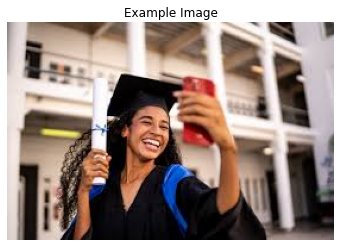

Predicted Caption: two men in black are standing in front of blue building


In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread('Example.jpeg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axis for a cleaner look
plt.title('Example Image')  # Optional: Add a title
plt.show()
print("Predicted Caption:", caption)

Features shape: torch.Size([1, 49, 512])


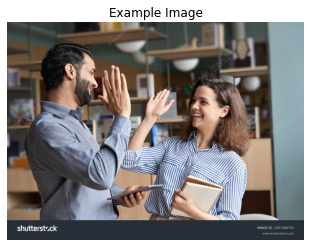

Predicted Caption: two men are posing for picture


In [14]:
new_image_path = 'Example_1.jpg'

# Extract features
features = extract_features_single_image(new_image_path)
print("Features shape:", features.shape)  # should be (1,49,512)

# Generate caption
caption = generate_caption(ictModel, features, max_length=max_seq_len)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread(new_image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axis for a cleaner look
plt.title('Example Image')  # Optional: Add a title
plt.show()
print("Predicted Caption:", caption)

Features shape: torch.Size([1, 49, 512])


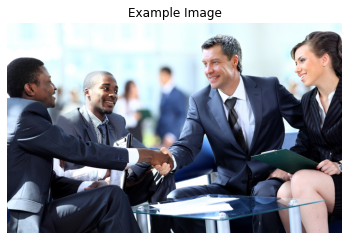

Predicted Caption: man is sitting on bench with woman and man who is looking at the camera


In [15]:
new_image_path = 'Example_2.jpg'

# Extract features
features = extract_features_single_image(new_image_path)
print("Features shape:", features.shape)  # should be (1,49,512)

# Generate caption
caption = generate_caption(ictModel, features, max_length=max_seq_len)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread(new_image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axis for a cleaner look
plt.title('Example Image')  # Optional: Add a title
plt.show()
print("Predicted Caption:", caption)

Features shape: torch.Size([1, 49, 512])


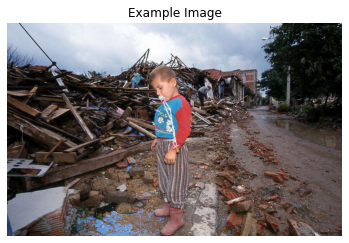

Predicted Caption: people in the air with blue shirt and blue shirt is standing in the background


In [16]:
new_image_path = 'Example_3.jpg'

# Extract features
features = extract_features_single_image(new_image_path)
print("Features shape:", features.shape)  # should be (1,49,512)

# Generate caption
caption = generate_caption(ictModel, features, max_length=max_seq_len)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread(new_image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axis for a cleaner look
plt.title('Example Image')  # Optional: Add a title
plt.show()
print("Predicted Caption:", caption)

Features shape: torch.Size([1, 49, 512])


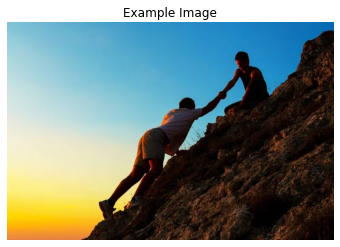

Predicted Caption: man in red shirt is climbing rock


In [17]:
new_image_path = 'Example_4.jpg'

# Extract features
features = extract_features_single_image(new_image_path)
print("Features shape:", features.shape)  # should be (1,49,512)

# Generate caption
caption = generate_caption(ictModel, features, max_length=max_seq_len)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread(new_image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axis for a cleaner look
plt.title('Example Image')  # Optional: Add a title
plt.show()
print("Predicted Caption:", caption)